# New Movie Studio Decision Analysis

by Karina Baculima, Rick Lataille, and Monica Pecha for Flatiron School

### Project Overview and Bottom Line

Paranormal Activity, a low budget film produced on 15,000 dollars, was able to grow into an 890 million dollar theatrical franchise!<sup>1</sup> 

This project presents an analysis of past movies based on how well they did in the box office. Our team reviews and processes the data in order to generate insights for Calculated Craft Productions. Ultimately we were able to come up with recommendations that the company’s new movie studio can use.

We found that maintaining budget discipline can lead to 2x the profitability! 


<sup>1</sup>*[Article](https://fortune.com/longform/jason-blum-exorcist-blumhouse-low-budget-horror-films/) written by Devin Gordon in 2023*

![action](https://cdn.inkspire.org/wp-content/uploads/2022/01/shutterstock_169841813-min.png)

<span>Photo by Samantha Pavich from <a href="https://inkspire.org/post/film-industry-where-is-the-justice/">inkspire.org</a></span>

## Business Problem

Calculated Craft Productions is expanding it's business to new industries. They asked our team to look into the data for movies within the US from 2010 to 2018. The company wants to know:

1. Will a movie studio with a smaller budget or a larger budget result in a lower financial risk? 
2. Which type of film has the highest payoffs? 
3. Which producers were the most successful at generating significant and reliable returns? 

## Data Understanding

For this project the dataset was taken from:

- IMDB 
- The Numbers Movie Budgets 
- Box Office Mojo Movie Gross

The entire dataset contains 3205 movies. Let's explore the processes done on the dataset.

- Data Preparation and Cleaning
- Data Limitations
- Data Visualization and Analysis


### Data preparation and Cleaning

Overall steps for this section:
- Check for duplicates
- Filter raw data by relevancy to business problem
- Address missing values
- Standardization of capitalization
- Keep columns necessary to answer business problem 

### Data Limitations

We encountered significant flaws in the data which limited our ability to perfectly match records across data sources.

- The dataset includes films completed and released to the market, and some films which are scheduled to be released, but does not include films which were never released, or their budgets. 

- Some spot checks of the data suggest that worldwide gross in particular is not reliable across all films.

- Financial reporting across studios can differ, in particular due to the manner in which compensation is paid, which could alter any profitability analysis.

- There are many below-the-line costs, such as press & advertising and cinema revenue-sharing, that differs from film to film and could have an effect on this analysis.

In [1]:
# import packages used throughout the analysis

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from random import gauss, seed
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import re
import sqlite3

%matplotlib inline

In [2]:
# read all csv and tsv data files into dataframes; ultimately we only used df1 and df5, but explored all five csv and tsv files

df1=pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df5=pd.read_csv("zippedData/bom.movie_gross.csv.gz")

In [3]:
#establish sql connection and read in the im.db

conn = sqlite3.connect("zippedData/im.db/im.db")

In [4]:
#joined three relevant SQL tables together

df_sql_merged = pd.read_sql("""
SELECT per.primary_name, bas.primary_title, bas.genres, bas.movie_id, bas.start_year
FROM persons as per
    JOIN principals as pri
    ON pri.person_id = per.person_id
    JOIN movie_basics as bas
    ON pri.movie_id = bas.movie_id
WHERE category = "producer"
""", conn)

In [5]:
# convert the release date column to datetime

df1['release_date'] = pd.to_datetime(df1['release_date'])
df1['year'] = df1['release_date'].apply(lambda x: x.year)
df1['month'] = df1['release_date'].apply(lambda x: x.month)

In [6]:
# create a key from the title and year

df_sql_merged['title_year'] = df_sql_merged['primary_title'] + df_sql_merged['start_year'].astype('str')
df1['title_year'] = df1['movie'] + df1['year'].astype('str')
df5['title_year'] = df5['title'] + df5['year'].astype('str')

In [7]:
# create regex pattern and replacement dictionary to sync names between data files

change_hyphen = re.compile('\s*-\s+')

replace_dict = {'â\x80\x99': "'",
                'â\x80\x94': ' - ',
                'â\x80\x93': ' - ',
                'â\x80¦': '…',
                'Ã\xad': 'í',
                'Ä\x81': 'ā',
                'Ã¤': 'ä',
                'Ã¥': 'å',
                'Ã¡': 'á',
                'Ã§': 'ç',
                'Ã©': 'é',
                'Ã¨': 'è',
                'Ã«': 'ë',
                'Ãª': 'ê',
                'à¬': 'ì',
                'Ä«': 'ī',
                'Ã´': 'ô',
                'Ã³': 'ó',
                'Ã¸': 'ø',
                'Ã¹': 'ù',
                'Ã¼': 'ü',
                'Ã»': 'ū',
                'Ã': 'à',    
                'Â': '',     
                change_hyphen: ': '
               }

In [8]:
# this identifies the correct pattern, and replaces all particular bads with goods

df1['movie'] = df1['movie'].replace(replace_dict, regex=True)
df_sql_merged['primary_title'] = df_sql_merged['primary_title'].replace(replace_dict, regex=True)

In [9]:
# this code removes $ and , from currency columns.  It takes a Series names as an argument and removes
# those two characters from each value, then recasts the value as int64

replace_chars = '\$|,'
columns_to_clean = ['production_budget', 'domestic_gross']
df1[columns_to_clean] = df1[columns_to_clean].apply(lambda x: x.str.replace(replace_chars,'').astype('int64')) 

In [10]:
# merge the csv files together and then merge it with the already joined sql tables
df_csv_merged = pd.merge(df1, df5, on='title_year', how='left')
df_csv_merged = df_csv_merged[df_csv_merged['domestic_gross_x'] != 0]
df_merged = pd.merge(df_csv_merged, df_sql_merged, on="title_year", how = "left")

In [11]:
# drop the additional columns not needed

df_merged = df_merged.drop(columns=["domestic_gross_y", "foreign_gross", "worldwide_gross", "year_y", "id", "start_year"])

In [12]:
# Clean column names and filter for films in the 2010-2018 time period

df_merged.rename(columns={'year_x': 'year', 'domestic_gross_x': 'domestic_gross'}, inplace=True)
earliest_date = pd.to_datetime('2010-01-01')
latest_date = pd.to_datetime('2018-12-31')
df_merged = df_merged.loc[(df_merged['release_date']>=earliest_date) & (df_merged['release_date']<=latest_date)]

### Data Visualizations and Analysis

###### EDA -1
.head, .tail, and .info to get a look at df_merged datase

In [13]:
df_merged.head()

,release_date,movie,production_budget,domestic_gross,year,month,title_year,title,studio,primary_name,primary_title,genres,movie_id
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,2011,5,Pirates of the Caribbean: On Stranger Tides2011,Pirates of the Caribbean: On Stranger Tides,BV,NaN,NaN,NaN,NaN
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,2015,5,Avengers: Age of Ultron2015,Avengers: Age of Ultron,BV,Kevin Feige,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",tt2395427
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,2017,12,Star Wars Ep. VIII: The Last Jedi2017,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2015,12,Star Wars Ep. VII: The Force Awakens2015,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-04-27,Avengers: Infinity War,300000000,678815482,2018,4,Avengers: Infinity War2018,Avengers: Infinity War,BV,NaN,NaN,NaN,NaN


In [14]:
df_merged.tail()

,release_date,movie,production_budget,domestic_gross,year,month,title_year,title,studio,primary_name,primary_title,genres,movie_id
6700,2016-03-18,Krisha,30000,144822,2016,3,Krisha2016,NaN,NaN,NaN,NaN,NaN,NaN
6703,2010-10-15,Down Terrace,30000,9812,2010,10,Down Terrace2010,NaN,NaN,NaN,NaN,NaN,NaN
6706,2017-01-27,Emily,27000,3547,2017,1,Emily2017,NaN,NaN,NaN,NaN,NaN,NaN
6712,2010-04-02,Breaking Upwards,15000,115592,2010,4,Breaking Upwards2010,NaN,NaN,NaN,NaN,NaN,NaN
6721,2012-01-13,Newlyweds,9000,4584,2012,1,Newlyweds2012,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3205 entries, 1 to 6721
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       3205 non-null   datetime64[ns]
 1   movie              3205 non-null   object        
 2   production_budget  3205 non-null   int64         
 3   domestic_gross     3205 non-null   int64         
 4   year               3205 non-null   int64         
 5   month              3205 non-null   int64         
 6   title_year         3205 non-null   object        
 7   title              2353 non-null   object        
 8   studio             2352 non-null   object        
 9   primary_name       2597 non-null   object        
 10  primary_title      2597 non-null   object        
 11  genres             2596 non-null   object        
 12  movie_id           2597 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 350.5+ 

###### EDA-2
explore and further prepare financial data

In [16]:
# create a profit column for each movie
df_merged['return'] = df_merged['domestic_gross'] - df_merged['production_budget']

In [17]:
# This cell creates a new column for profit as % of budget

df_merged['percent_return'] = (df_merged['domestic_gross'] / df_merged['production_budget'])

In [18]:
# Drop any duplicates of the title_year key
#create a new dataframe

df_budget = df_merged.drop_duplicates(subset=['title_year']).copy()

In [19]:
# create buckets and turn them into a column
df_budget['bucket'] = pd.qcut(df_budget['production_budget'], q=5, labels=False)

In [20]:
# This code creates a scaled value for each film budget, along with the bucket boundaries and means

buckets = list(reversed(df_budget['bucket'].unique()))
bucket_bounds = np.zeros((len(buckets),2))
bucket_range = np.zeros(len(buckets))
bucket_means = np.zeros(len(buckets))

for i in buckets:
    bucket_bounds[i,0] = df_budget.loc[df_budget['bucket']==i]['production_budget'].min()
    bucket_bounds[i,1] = df_budget.loc[df_budget['bucket']==i]['production_budget'].max()
    bucket_range[i] = bucket_bounds[i,1] - bucket_bounds[i,0]
    bucket_means[i] = df_budget.loc[df_budget['bucket']==i]['return'].mean()

df_budget['scaled_value'] = ((df_budget['production_budget']
                             - bucket_bounds[df_budget['bucket'],0])
                             / bucket_range[df_budget['bucket']] 
                             + df_budget['bucket'])
df_budget['bucket_low'] = bucket_bounds[df_budget['bucket'],0]
df_budget['bucket_high'] = bucket_bounds[df_budget['bucket'],1]
df_budget['bucket_mean'] = bucket_means[df_budget['bucket']]

In [21]:
#export the df_budget to use it in Tableau
df_budget.to_csv('Data/budget.csv')

In [22]:
grouped_data = df_budget.groupby('year')['percent_return'].mean().reset_index()

In [23]:
# Recopy df_merged for genres analysis, dropping any duplicates of the title_year key,
# any unnecessary columns and null values in 'genres'

df_genre = df_merged.drop_duplicates(subset=['title_year']).copy()
df_genre.drop(columns=['year', 'month', 'primary_name', 'primary_title', 'title', 'studio'], inplace=True)
df_genre.dropna(subset=['genres'], inplace=True)

In [24]:
# Get dummies for genre to perform genre analysis

genres = list(df_genre['genres'].str.get_dummies(",").columns)
df_genre = df_genre.join(df_genre['genres'].str.get_dummies(","))

In [25]:
# Create a summary stats table by genre

df_genre_table = pd.DataFrame(index=range(len(genres)), columns=range(4))

j = 0
for genre in genres:
    genre_count = df_genre[genre].sum()
    avg_profit = (df_genre['return'].dot(df_genre[genre])*100 / genre_count)
    avg_budget = ((df_genre['production_budget'].dot(df_genre[genre])/ genre_count)/1000000)
    df_genre_table.loc[j, 0] = genre
    df_genre_table.loc[j, 1] = genre_count
    df_genre_table.loc[j, 2] = avg_budget
    df_genre_table.loc[j, 3] = avg_profit
    j += 1

In [26]:
# Write df_genre to an excel file called genres2.xlsx
with pd.ExcelWriter('Data/genres2.xlsx', engine='openpyxl') as writer:
    df_genre.to_excel(writer, sheet_name='Data', index=False)

with pd.ExcelWriter('Data/genres2.xlsx', engine='openpyxl', mode='a') as writer:
    df_genre_table.to_excel(writer, sheet_name='Summary_Table', header=['Genre', 'Count', 'Avg Budget', 'Avg Sales/Budget'],
                        index=False)

###### EDA-3
basic visualizations exploring the data

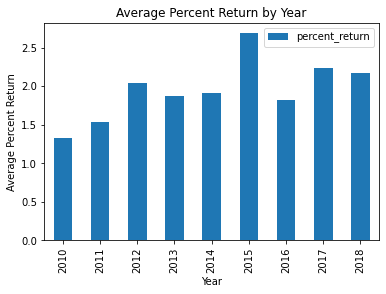

In [27]:
#Overall, movies appear to be increasing in their returns overtime, prior to 2019.
#In general it would appear that going into the movie business can be profitable.
grouped_data.plot(x='year', y='percent_return', kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Percent Return')
plt.title('Average Percent Return by Year')
plt.show()

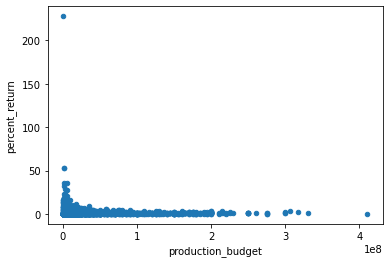

In [28]:
#It's difficult to see the cluster of movies hovering around the low budget and low returns, 
#but the concentration that moves up the y-axis around 0 on the x-axis suggests that 
# lower budget movies might produce better overall returns. 

df_budget.plot.scatter(x='production_budget', y='percent_return')
plt.show()

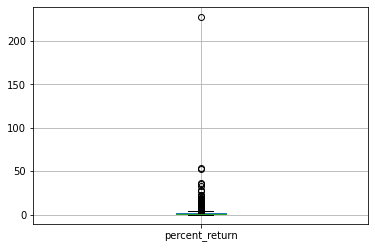

In [29]:
# The primary takeaway from this figure is out incredible outlier. 
# There are several additional outliers as well, 
# and they mask us being able to see the distribution of the other movie's returns

df_budget.boxplot(column='percent_return')
plt.show()

###### Analysis

run some basic statistics (mean, std), z-test, and simple linear regression

In [30]:
# look at the mean and standard deviation for overall budget, overall domestic gross, and percent return
mean_budget = df_budget["production_budget"].mean()
std_budget = df_budget["production_budget"].std()
mean_domestic_gross = df_budget["domestic_gross"].mean()
std_domestic_gross = df_budget["domestic_gross"].std()
mean_percent_return = df_budget["percent_return"].mean()
std_percent_return = df_budget["percent_return"].std()

f'''
Mean Budget: {mean_budget},
Std Budget: {std_budget},
Mean Domestic Gross: {mean_domestic_gross},
Std Domestic Gross: {std_domestic_gross},
Mean Percent Return: {mean_percent_return},
Std Percent Return: {std_percent_return}
'''

'\nMean Budget: 42403013.56855995,\nStd Budget: 54103688.08852946,\nMean Domestic Gross: 53880767.41308089,\nStd Domestic Gross: 85449576.03345673,\nMean Percent Return: 1.9218520292761037,\nStd Percent Return: 6.4306211954827734\n'

In [31]:
#count of movies by producer
producer_counts = df_budget["primary_name"].value_counts()
producer_counts

Jason Blum          18
Ryan Kavanaugh       8
Todd Garner          8
Peter Chernin        7
Judd Apatow          7
                    ..
Nick Wechsler        1
Wendy Finerman       1
Michael Gottwald     1
Kristine Belson      1
Bill Paxton          1
Name: primary_name, Length: 768, dtype: int64

In [32]:
# create a dataframe looking at low volume movie producers
data = df_budget
df_low = pd.DataFrame(data)

value_counts = df_low['primary_name'].value_counts()

#low volumne is defined as one to five movies
min_count = 1
max_count = 5

# create the subset dataframe
subset_low_df = df_low[df_low['primary_name'].isin(value_counts[(value_counts >= min_count) & 
                                                                (value_counts <= max_count)].index)]

#calculate the mean and standard deviation for low volume producers
mean_df_low = subset_low_df["percent_return"].mean()
std_df_low = subset_low_df["percent_return"].std()

f'''
Mean Percent Return: {mean_df_low},
Std Percent Return: {std_df_low}
'''

'\nMean Percent Return: 2.036702986165756,\nStd Percent Return: 7.674686106948405\n'

In [33]:
# create a dataframe looking at high volume movie producers
data = df_budget
df_high = pd.DataFrame(data)

value_counts = df_high['primary_name'].value_counts()

# high volumne is defined as six or more movies
min_count = 6
max_count = 30

# create the subset dataframe
subset_high_df = df_high[df_high['primary_name'].isin(value_counts[(value_counts >= min_count) & 
                                                                   (value_counts <= max_count)].index)]

#calculate the mean and standard deviation for high volume producers
mean_df_high = subset_high_df["percent_return"].mean()
std_df_high = subset_high_df["percent_return"].std()

f'''
Mean Percent Return: {mean_df_high},
Std Percent Return: {std_df_high}
'''


'\nMean Percent Return: 2.8691577255904988,\nStd Percent Return: 4.808848542519632\n'

In [34]:
# putting the subset low/high volume producers back together with a high/low key
combined_df = pd.concat([subset_high_df, subset_low_df], keys=['HighProducer', 'LowProducer'])
combined_df.head()
combined_df.tail()
combined_df.to_csv('Data/visual2.csv')

In [35]:
# we are choosing to do a z-test here; we are considering the imdb sql dataset as population level box office movie data

population_mean = 0.92185
sample_mean = 1.86916
standard_deviation = 6.43062
sample_size = 114

# z-statistic
z = (sample_mean - population_mean) / (standard_deviation / np.sqrt(sample_size))

print("Z-statistic:", z)

Z-statistic: 1.5728659132294835


In [36]:
# drop the z statistic into a cdf to get a p-value
1-stats.norm.cdf(z)

0.057874934695254954

In [37]:
# conduct a linear regression looking at the budget as a predictor of gross (domestic)
X=df_budget[["production_budget"]] #predictor (used to predict the target)
y=df_budget[["domestic_gross"]] #target (predicted by the budget)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [38]:
# coefficients represent the change in domestic gross for a one-unit change in the production budget 
y_pred = model.predict(X)
print("Predicted values:", y_pred)

coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Predicted values: [[4.77489194e+08]
 [3.85449673e+08]
 [3.69802955e+08]
 ...
 [5.12741771e+06]
 [5.11361179e+06]
 [5.10670882e+06]]
Coefficients: [[1.15049401]]
Intercept: [5096354.37653386]


#### Alternative regression: logarithmic

In [40]:
def logarithmic_curve(x, a, b):
    return a * np.log(x) + b

In [41]:
# estimate the coefficients of a logarithmic curve
x_data = df_budget['production_budget']
y_data = df_budget['percent_return']
popt, pcov = curve_fit(logarithmic_curve, x_data, y_data)
a_est, b_est = popt

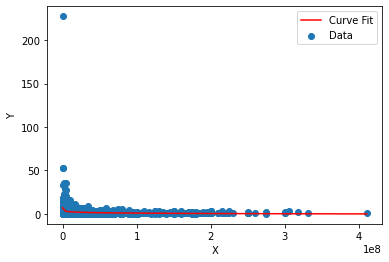

In [42]:
# Generate x and y values for plotting
x_values = np.linspace(min(x_data), max(x_data), 100)
y_values = a_est * np.log(x_values) + b_est

# Plot the data points
plt.scatter(x_data, y_data, label='Data')

# Plot the curve
plt.plot(x_values, y_values, color='red', label='Curve Fit')

# Label the axes and add a legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

In [43]:
# export the budget dataframe for Tableau analysis
df_budget.to_csv('Data/visuals.csv')

## Conclusion
Our data analysis shows that:

- Keeping budgets small leads to higher profitability over time

- Horror, mystery, thriller and romance movies are more reliably profitable

- Making more movies leads to more profitability